# Understanding Lucata Plotting Tools

### Lesson Objectives

Upon completing this notebook you should be able to understand and apply the following concepts:

1) Run a simulation with timing that generates statistics for plotting.
2) Evaluate the outputs from plotting scripts.
3) Look at two different kinds of spawn primitives and compare them using their plots.

### Simulating code for Profiling

In [8]:
%%bash
. /tools/emu/pathfinder-sw/set-lucata-env.sh
emusim.x --capture_timing_queues -m 21 --total_nodes 1 --output_instruction_count -- hello-world.mwx

Lucata tools are added to current path from /tools/emu/pathfinder-sw/22.02
Start untimed simulation with local date and time= Fri Jul 15 15:03:15 2022

End untimed simulation with local date and time= Fri Jul 15 15:03:15 2022

SysC Enumeration done. Program launching...
Simulation @0 s with local date and time= Fri Jul 15 15:03:15 2022

Hello, world!

Info: /OSCI/SystemC: Simulation stopped by user.



        SystemC 2.3.3-Accellera --- Feb 22 2022 09:27:12
        Copyright (c) 1996-2018 by all Contributors,
        ALL RIGHTS RESERVED


In [9]:
!ls hello-world.*

hello-world.c	 hello-world.mps  hello-world.tqd  hello-world.vsf
hello-world.cdc  hello-world.mwx  hello-world.uis


We now have several different output files. These are detailed in Ch. 7.6 of the Programming Guide and are as follows:
* hello-world.mwx - Lucata executable
* hello-world.cdc - Configuration data output file; includes system information and wall-clock time
* hello-world.mps - Memory map output; shows memory operation types and thread enqueuing
* hello-world.tqd - Timed activity tracing; includes live threads, thread activity counts, and requests
* hello-world.uis - Instruction count statistics; shows the number of instructions per function in the application and number of migrations
* hello-world.vsf - Verbose statistics information; advanced counter statistics for debugging bottlenecks

These files can be used with plotting tools to provide detailed output on the simulation of the application.

In [10]:
%%bash
. /tools/emu/pathfinder-sw/set-lucata-env.sh
make_tqd_plots.py hello-world.tqd

Lucata tools are added to current path from /tools/emu/pathfinder-sw/22.02
Generating hello-world.Live_Threads.png
Generating hello-world.Thread_Activity.png
Generating hello-world.MSP_Activity.png


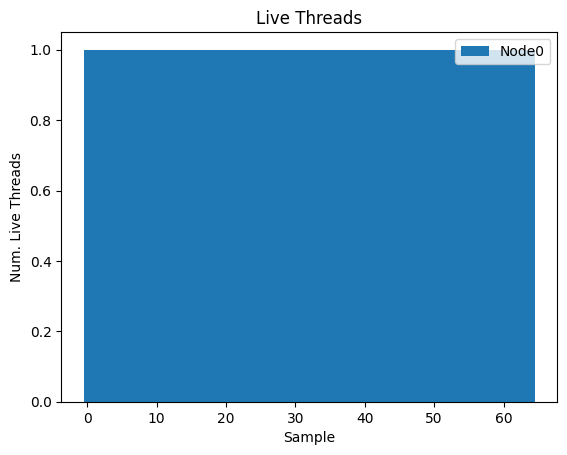

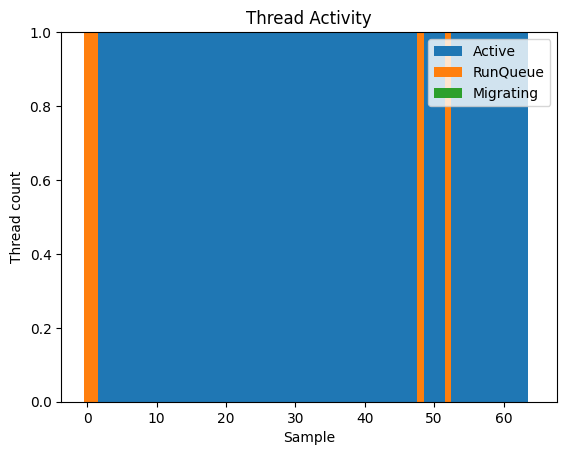

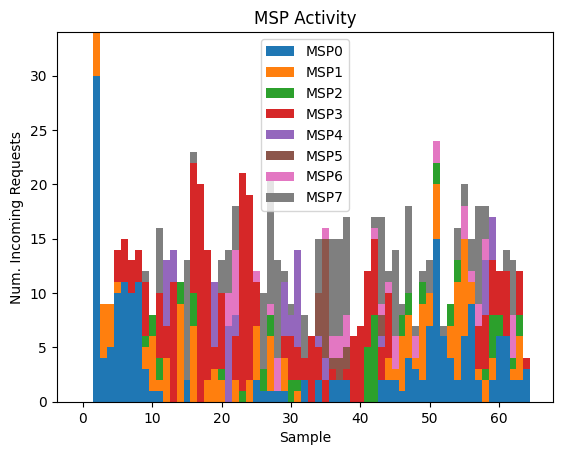

In [11]:
from IPython.display import Image, display
display(Image(filename="hello-world.Live_Threads.png"))
display(Image(filename="hello-world.Thread_Activity.png"))
display(Image(filename="hello-world.MSP_Activity.png"))

In [12]:
%%bash
. /tools/emu/pathfinder-sw/set-lucata-env.sh
make_map_plots.py hello-world.mps

Lucata tools are added to current path from /tools/emu/pathfinder-sw/22.02
Generating hello-world.Thread_Enqueue_Map.png
Generating hello-world.Memory_Read_Map.png
Generating hello-world.Memory_Write_Map.png
Generating hello-world.Atomic_Transaction_Map.png
Generating hello-world.Remote_Transaction_Map.png


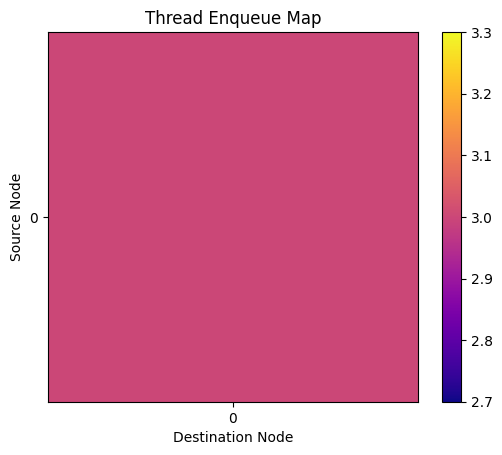

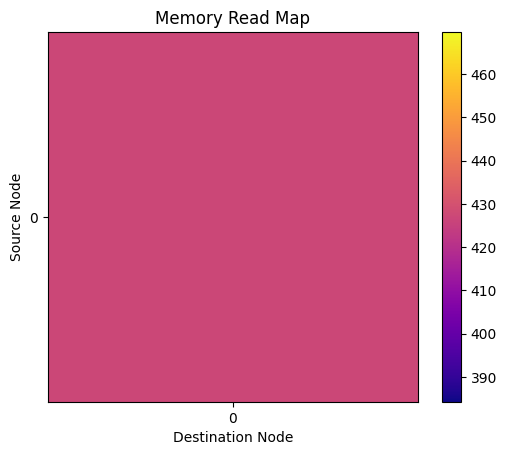

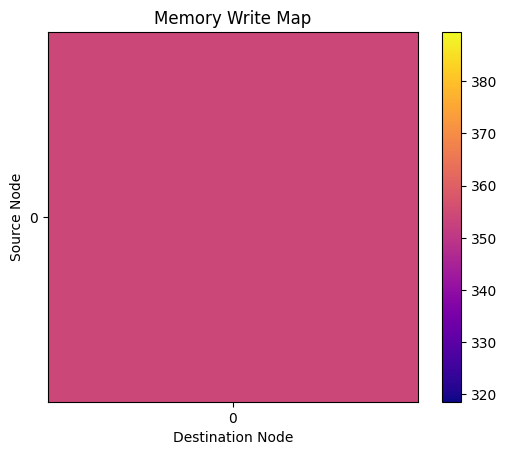

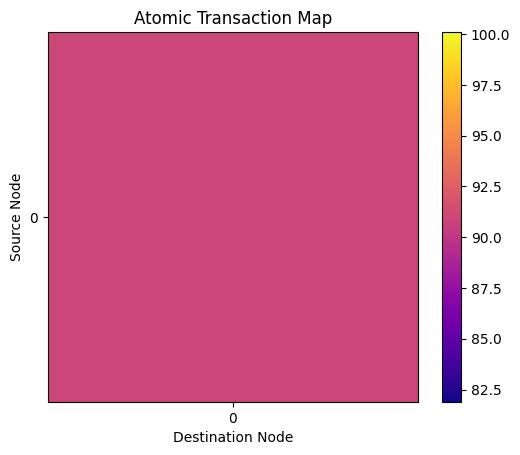

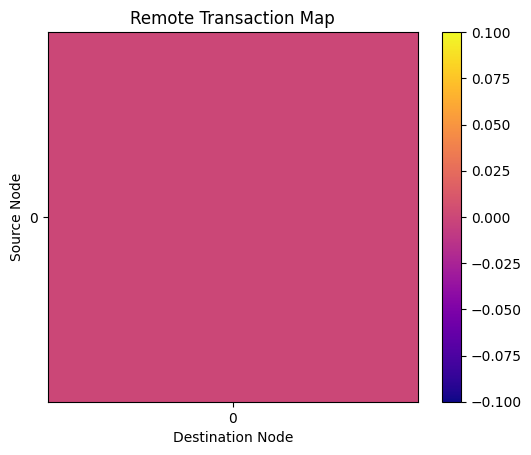

In [13]:
display(Image(filename="hello-world.Thread_Enqueue_Map.png"))
display(Image(filename="hello-world.Memory_Read_Map.png"))
display(Image(filename="hello-world.Memory_Write_Map.png"))
display(Image(filename="hello-world.Atomic_Transaction_Map.png"))
display(Image(filename="hello-world.Remote_Transaction_Map.png"))

In [18]:
%%bash
. /tools/emu/pathfinder-sw/set-lucata-env.sh
make_uis_plots.py hello-world.uis

Lucata tools are added to current path from /tools/emu/pathfinder-sw/22.02


Traceback (most recent call last):
  File "/tools/emu/pathfinder-sw/22.02/bin/make_uis_plots.py", line 7, in <module>
    import parser as emup
  File "/net/tools/emu/pathfinder-sw/22.02/bin/parser.py", line 2, in <module>
    import matplotlib.pyplot as plt
  File "/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py", line 116, in <module>
    _backend_mod, new_figure_manager, draw_if_interactive, _show = pylab_setup()
  File "/usr/lib/python2.7/dist-packages/matplotlib/backends/__init__.py", line 60, in pylab_setup
    [backend_name], 0)
ImportError: No module named ipykernel.pylab.backend_inline


In [19]:
display(Image(filename="hello-world_total_instructions.png"))

FileNotFoundError: [Errno 2] No such file or directory: 'hello-world_total_instructions.png'

## Hello World Spawn Example

That example kept one thread alive and migrating between nodelets.  This one, hello-world-spawn.c, uses Cilk's thread spawning intrinsic:

```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <cilk.h>

#include <memoryweb.h>
#include <timing.h>

const char str[] = "Hello, world!";

static inline void copy_ptr (char *pc, const long *pl) { *pc = (char)*pl; }

replicated long * ptr;
replicated char * str_out;

int main (void)
{
     long n = strlen (str) + 1;

     mw_replicated_init ((long*)&ptr, (long)mw_malloc1dlong (n));
     mw_replicated_init ((long*)&str_out, (long)malloc (n * sizeof (char)));

     starttiming();

     for (long k = 0; k < n; ++k)
          ptr[k] = (long)str[k]; // Remote writes

     for (long k = 0; k < n; ++k)
          cilk_spawn copy_ptr (&str_out[k], &ptr[k]);

     printf("%s\n", str_out);  // Migration back
}
```

In [22]:
%%bash
. /tools/emu/pathfinder-sw/set-lucata-env.sh
FLAGS="-I/tools/lucata/pathfinder-sw/22.02/include/memoryweb/ -L/tools/lucata/pathfinder-sw/22.02/lib -lmemoryweb"
emu-cc -o hello-world-spawn.mwx $FLAGS hello-world-spawn.c
emusim.x --capture_timing_queues --output_instruction_count -- hello-world-spawn.mwx
ls hello-world-spawn*
make_tqd_plots.py hello-world-spawn.tqd
make_map_plots.py hello-world-spawn.mps
make_uis_plots.py hello-world-spawn.uis

Lucata tools are added to current path from /tools/emu/pathfinder-sw/22.02
hello-world-spawn-at.c
hello-world-spawn-at.mwx
hello-world-spawn.c
hello-world-spawn.cdc
hello-world-spawn.mps
hello-world-spawn.mwx
hello-world-spawn.tqd
hello-world-spawn.uis
hello-world-spawn.vsf



        SystemC 2.3.3-Accellera --- Feb 22 2022 09:27:12
        Copyright (c) 1996-2018 by all Contributors,
        ALL RIGHTS RESERVED
ERROR: NodeMemory: out of memory!!
Traceback (most recent call last):
  File "/tools/emu/pathfinder-sw/22.02/bin/make_tqd_plots.py", line 41, in <module>
    filedata=json.load(fname)
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)
Traceback (most recent call last):
  File "/tools/emu/pathfinder-sw/22.02/bin/make_map_plots.py", line 

Then we can compare the output of the normal Hello World and the Spawn Hello World for the statistics that are different.

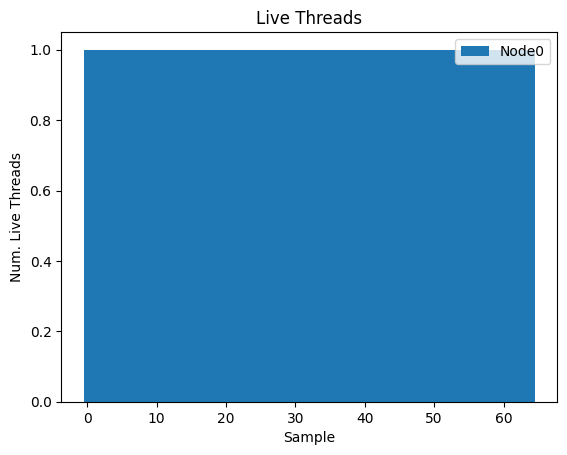

FileNotFoundError: [Errno 2] No such file or directory: 'hello-world-spawn.Live_Threads.png'

In [23]:
display(Image(filename="hello-world.Live_Threads.png"))
display(Image(filename="hello-world-spawn.Live_Threads.png"))
display(Image(filename="hello-world.Thread_Activity.png"))
display(Image(filename="hello-world-spawn.Thread_Activity.png"))
display(Image(filename="hello-world.MSP_Activity.png"))
display(Image(filename="hello-world-spawn.MSP_Activity.png"))
display(Image(filename="hello-world_total_instructions.png"))
display(Image(filename="hello-world-spawn_total_instructions.png"))

## Advanced Implementation - Spawn At

This example just shows one additional variation of using a `cilk_spawn_at` call to spawn threads at a remote node

```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <cilk.h>

#include <memoryweb.h>
#include <timing.h>

static const char str[] = "Hello, world!";

static inline void copy_ptr (char *pc, const long *pl) { *pc = (char)*pl; }

replicated long * ptr;
replicated char * str_out;

int main (void)
{
     long n = strlen (str) + 1;

     mw_replicated_init ((long*)&ptr, (long)mw_malloc1dlong (n));
     mw_replicated_init ((long*)&str_out, (long)malloc (n * sizeof (char)));

     starttiming();

     for (long k = 0; k < n; ++k)
          ptr[k] = (long)str[k]; // Remote writes

     for (long k = 0; k < n; ++k) {
          cilk_spawn_at(&ptr[k]) copy_ptr (&str_out[k], &ptr[k]);
     }

     printf("%s\n", str_out);  // Migration back
}
```

In [24]:
%%bash
. /tools/emu/pathfinder-sw/set-lucata-env.sh
FLAGS="-I/tools/lucata/pathfinder-sw/current/include/memoryweb/ -L/tools/lucata/pathfinder-sw/current/lib -lmemoryweb"
emu-cc -o hello-world-spawn-at.mwx $FLAGS hello-world-spawn-at.c
emusim.x --capture_timing_queues --output_instruction_count -- hello-world-spawn-at.mwx
ls hello-world-spawn-at*
make_map_plots.py hello-world-spawn-at.mps
make_tqd_plots.py hello-world-spawn-at.tqd
make_uis_plots.py hello-world-spawn-at.uis

Lucata tools are added to current path from /tools/emu/pathfinder-sw/22.02
hello-world-spawn-at.c
hello-world-spawn-at.cdc
hello-world-spawn-at.mps
hello-world-spawn-at.mwx
hello-world-spawn-at.tqd
hello-world-spawn-at.vsf



        SystemC 2.3.3-Accellera --- Feb 22 2022 09:27:12
        Copyright (c) 1996-2018 by all Contributors,
        ALL RIGHTS RESERVED
ERROR: NodeMemory: out of memory!!
Traceback (most recent call last):
  File "/tools/emu/pathfinder-sw/22.02/bin/make_map_plots.py", line 20, in <module>
    data=json.load(file)
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)
Traceback (most recent call last):
  File "/tools/emu/pathfinder-sw/22.02/bin/make_tqd_plots.py", line 41, i

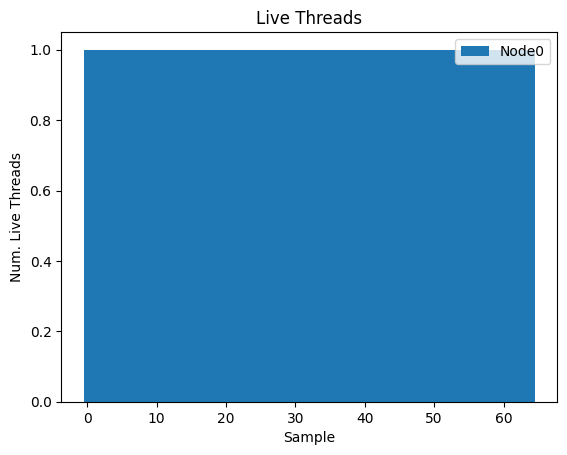

FileNotFoundError: [Errno 2] No such file or directory: 'hello-world-spawn-at.Live_Threads.png'

In [25]:
display(Image(filename="hello-world.Live_Threads.png"))
display(Image(filename="hello-world-spawn-at.Live_Threads.png"))
display(Image(filename="hello-world.Thread_Activity.png"))
display(Image(filename="hello-world-spawn-at.Thread_Activity.png"))
display(Image(filename="hello-world.MSP_Activity.png"))
display(Image(filename="hello-world-spawn-at.MSP_Activity.png"))
display(Image(filename="hello-world_total_instructions.png"))
display(Image(filename="hello-world-spawn-at_total_instructions.png"))

Once we've finished our testing, we can then clean up some of the logfiles that we used for this example. Here we'll run `make clean` to save our figures in a separate directory and finish this demo.

In [26]:
!make clean

rm -f *.mwx *.tqd *.cdc *.vsf *.mps; \
./helpers/backup_imgs.sh
